# Exploratory Data Analysis of the PFT Dataset
This notebook shows some exploratory plots of the PFT dataset to understand the data better.

### Imports

In [8]:
import xarray as xr
import numpy as np
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Load preprocessed dataset

In [3]:
ds_pft = xr.open_dataset("data/regridded_pft_data/pft-yearly-sliced.nc")

PFT_VARS = [
    "BARE","BUILT",
    "GRASS-MAN","GRASS-NAT",
    "SHRUBS-BD","SHRUBS-BE","SHRUBS-ND","SHRUBS-NE",
    "TREES-BD","TREES-BE","TREES-ND","TREES-NE",
    "WATER_OCEAN","WATER_INLAND","SNOWICE"
]

### EDA

##### Variables over time
These plots show how the mean fraction (area-weighted) of different PFT variables varies over time.

We can observe that the types seem to change with some specific trend each but the differences are very marginal.

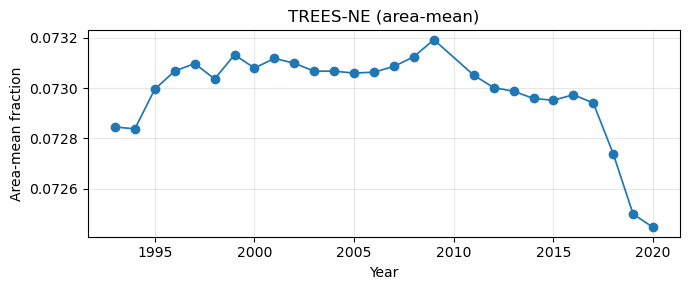

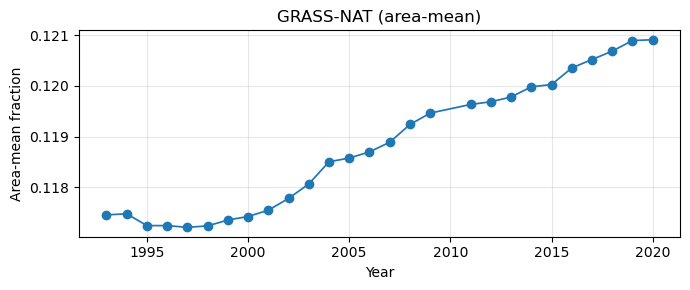

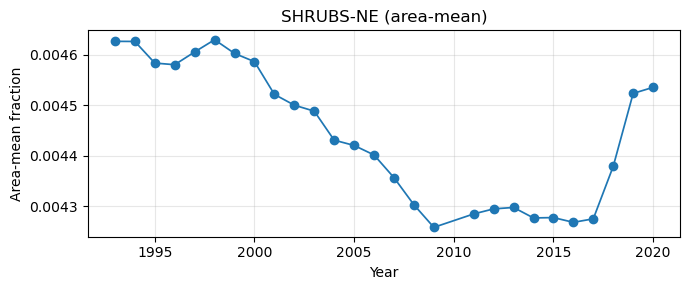

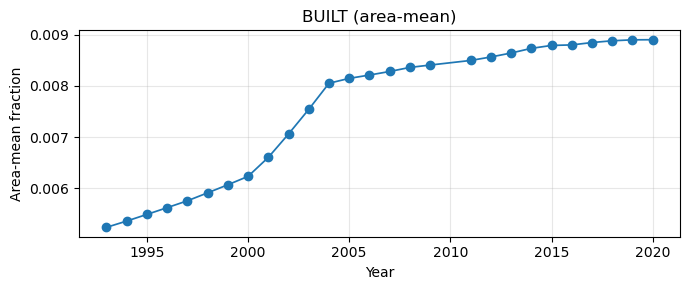

In [7]:
def earth_radius(lat):
    '''
    Calculate the radius of Earth based on latitude assuming oblate spheroid defined by WGS84
    '''
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)

    lat_rad = np.deg2rad(lat)
    lat_gc = np.arctan((1 - e2) * np.tan(lat_rad))

    radius = (a * (1 - e2)**0.5) / (1 - (e2 * np.cos(lat_gc)**2))**0.5
    
    return radius

def area_weights(lat_deg: xr.DataArray, lon_deg: xr.DataArray):
    """
    Return 1D array of cell areas (m^2 per cell, *per longitude*) for each latitude row
    on a regular lat/lon grid with uniform spacing.

    lat_deg, lon_deg: 1D arrays of grid *centers* in degrees (uniform spacing assumed)
    """

    R = earth_radius(lat_deg)

    dlat_deg = abs(np.diff(lat_deg).mean())
    dlon_deg = abs(np.diff(lon_deg).mean())
    
    lat_rad    = np.deg2rad(lat_deg)
    dlat_rad   = np.deg2rad(dlat_deg)
    dlon_rad   = np.deg2rad(dlon_deg)

    lat_up   = np.clip(lat_rad + dlat_rad/2, -np.pi/2,  np.pi/2)
    lat_down = np.clip(lat_rad - dlat_rad/2, -np.pi/2,  np.pi/2)

    w_lat = np.square(R) * (np.sin(lat_up) - np.sin(lat_down)) * dlon_rad 

    w_lat_values = w_lat.values if isinstance(w_lat, xr.DataArray) else w_lat
    lat_values = lat_deg.values if isinstance(lat_deg, xr.DataArray) else lat_deg
    
    area_weights = xr.DataArray(
        w_lat_values,
        dims=["latitude"],
        coords={"latitude": lat_values},
        attrs={
            "long_name": "area_weight_per_cell",
            "description": "Area weight per grid cell (m^2 per longitude cell)",
            "units": "m^2",
        }
    )

    return area_weights

def plot_time_series(ds, var):
    weights_lat = area_weights(ds['latitude'], ds['longitude'])
    weights_2d = weights_lat.broadcast_like(ds[var].isel(year=0, drop=True))

    series = ds[var].weighted(weights_2d).mean(dim=('latitude','longitude'))
    years = ds['year'].values

    fig = plt.figure(figsize=(7,3))
    plt.plot(years, series, marker='o', lw=1.25)
    plt.ylabel('Area-mean fraction')
    plt.xlabel('Year')
    plt.title(f'{var} (area-mean)'); 
    plt.grid(True, alpha=0.3); 
    plt.tight_layout()
    plt.show()
    return fig

# Create the plots
figure_1 = plot_time_series(ds_pft, 'TREES-NE')
figure_2 = plot_time_series(ds_pft, 'GRASS-NAT')
figure_3 = plot_time_series(ds_pft, 'SHRUBS-NE')
figure_4 = plot_time_series(ds_pft, 'BUILT')

# Save the plots as png files
figure_1.savefig('figures/trees_ne_timeseries.png', dpi=300, bbox_inches='tight')
figure_2.savefig('figures/grass_nat_timeseries.png', dpi=300, bbox_inches='tight')
figure_3.savefig('figures/shrubs_ne_timeseries.png', dpi=300, bbox_inches='tight')
figure_4.savefig('figures/built_timeseries.png', dpi=300, bbox_inches='tight')

##### PFT variables
These plots show different PFT variables on a map for specific years

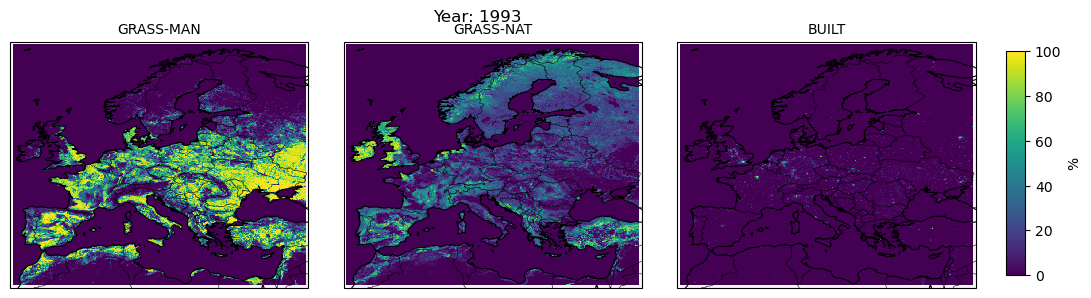

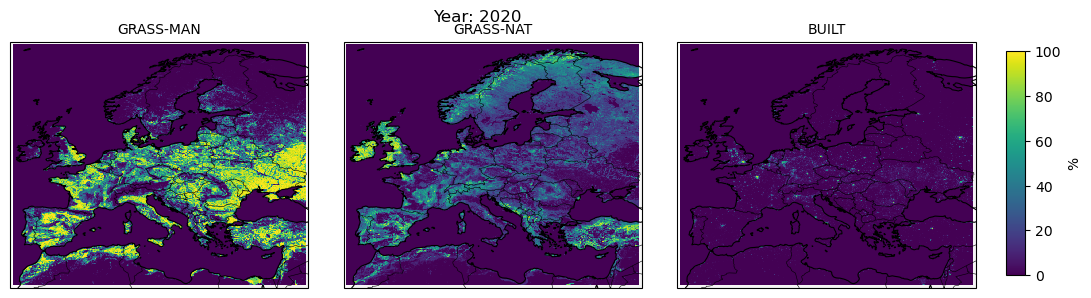

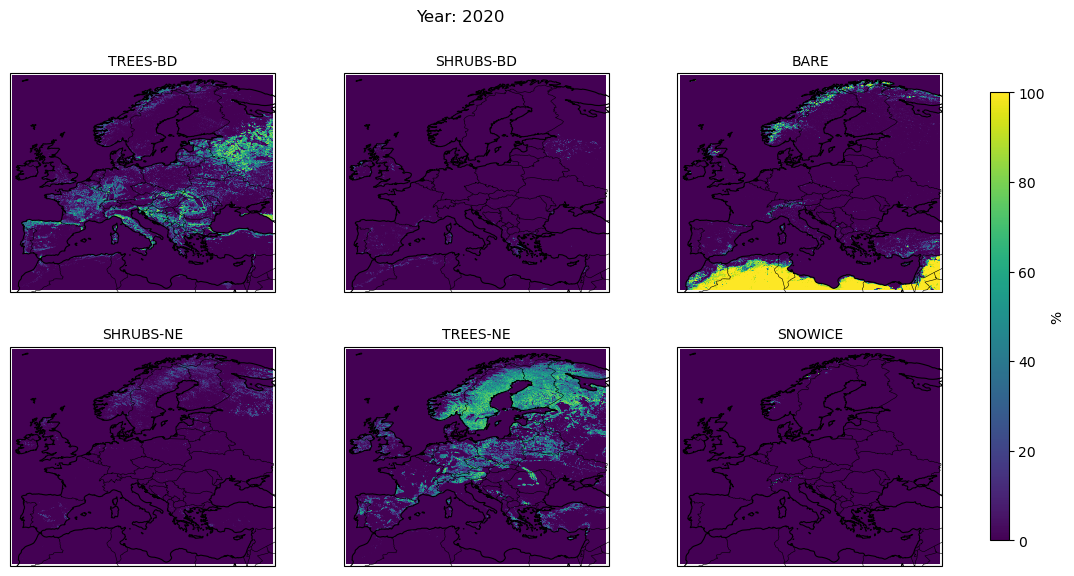

In [17]:
def plot_pft_panel(ds, vars_to_plot, year, ncols=3, vmin=0.0, vmax=1.0, cmap='viridis', as_percent=False):
    
    projection = ccrs.PlateCarree()

    lat = ds['latitude'].values
    lon = ds['longitude'].values
    extent = [float(lon.min())-0.5, float(lon.max())+0.5,
              float(lat.min())-0.5, float(lat.max())+0.5]

    n = len(vars_to_plot)
    nrows = math.ceil(n / ncols)

    fig_height = 3.2 * nrows
    fig_width  = 4.2 * ncols
    fig = plt.figure(figsize=(fig_width, fig_height))

    for i, var in enumerate(vars_to_plot, 1):
        ax = plt.subplot(nrows, ncols, i, projection=projection)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines('50m', linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.LAND, facecolor='whitesmoke', zorder=0)

        da = ds[var].sel(year=year)
        to_plot = da * (100.0 if as_percent else 1.0)

        to_plot.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            cmap=cmap, vmin=(vmin*100 if as_percent else vmin), vmax=(vmax*100 if as_percent else vmax),
            add_colorbar=False
        )
        ax.set_title(var, fontsize=10)

    cbar_label = f"{'%' if as_percent else 'fraction'}"
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin=(vmin*100 if as_percent else vmin), vmax=(vmax*100 if as_percent else vmax))
    fig.colorbar(sm, cax=cax, label=cbar_label)
    fig.suptitle(f"Year: {year}", y=0.98, fontsize=12)
    plt.subplots_adjust(right=0.9, hspace=0.25, wspace=0.08)

    return fig

# Create the plots
vars_to_plot = ["GRASS-MAN","GRASS-NAT","BUILT"]
figure_5 = plot_pft_panel(ds_pft, vars_to_plot, year=1993, ncols=3, as_percent=True)
figure_6 = plot_pft_panel(ds_pft, vars_to_plot, year=2020, ncols=3, as_percent=True)

vars_to_plot = ["TREES-BD","SHRUBS-BD","BARE","SHRUBS-NE","TREES-NE","SNOWICE"]
figure_7 = plot_pft_panel(ds_pft, vars_to_plot, year=2020, ncols=3, as_percent=True)

# Save the plots as png files
figure_5.savefig('figures/pft_panel_1993.png', dpi=300, bbox_inches='tight')
figure_6.savefig('figures/pft_panel_2020_1.png', dpi=300, bbox_inches='tight')
figure_7.savefig('figures/pft_panel_2020_2.png', dpi=300, bbox_inches='tight')